# NOAA GEFS Basin Forecasts and Historical Data

This notebook extracts forecast data for each basin centroid from the NOAA GEFS 35-day forecast dataset, fetches corresponding historical weather data using Open-Meteo, and combines them into a single dataset.

## Overview

The process consists of the following steps:
1. Load basin centroid coordinates from a CSV file
2. Connect to the NOAA GEFS forecast dataset
3. Extract forecast data for each basin location using all available initialization times
4. Determine the time range based on forecast data
5. Fetch historical weather data for the same basins and time range
6. Interpolate forecast data to hourly resolution
7. Merge the historical and hourly forecast data into a combined dataset
8. Visualize and analyze the combined forecast and historical data
9. Save the combined hourly data to NetCDF files

In [1]:
# Import required libraries
import os
import sys
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings

# Add src directory to path if it's not already in the path
if '../src' not in sys.path:
    sys.path.append('../src')
from fetch_basin_forecasts import (
    load_basin_centroids,
    fetch_forecasts_for_basins,
    interpolate_to_hourly,
)
from fetch_basin_historical import fetch_historical_for_basins # Import the new function

# Suppress warnings
warnings.filterwarnings('ignore')

## Define Paths for Input and Output Data

In [2]:
# Define paths for input and output data
basin_centroids_file = "../data/basin_centroids.csv"  # File containing basin centroid coordinates
output_dir = "../data/basin_data"  # Directory for output data (plots and netcdf)

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

print(f"Basin centroids file: {basin_centroids_file}")
print(f"Output directory: {output_dir}")

Basin centroids file: ../data/basin_centroids.csv
Output directory: ../data/basin_data


## Load Basin Centroids

Load the basin centroid coordinates from the CSV file.

In [3]:
# Load basin centroids
centroids = load_basin_centroids(basin_centroids_file)

# Display the basin coordinates
display(centroids)

Loaded 5 basin centroids from ../data/basin_centroids.csv


,basin_name,latitude,longitude
0,innerste_reservoir_catchment_Basin_0,51.834451,10.307828
1,oker_reservoir_catchment_Basin_0,51.816468,10.447276
2,ecker_reservoir_catchment_Basin_0,51.810056,10.584058
3,soese_reservoir_catchment_Basin_0,51.752310,10.383225
4,grane_reservoir_catchment_Basin_0,51.884391,10.357203


## Load NOAA GEFS Forecast Dataset

Connect to the online NOAA GEFS forecast dataset hosted by dynamical.org.

In [4]:
# Install dependencies if needed
# %pip install "xarray[complete]>=2025.1.2" "zarr>=3.0.4" requests aiohttp

In [5]:
# Load the NOAA GEFS forecast dataset
print("Loading NOAA GEFS dataset...")
ds = xr.open_zarr(
    "https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com", 
    decode_timedelta=True
)

print("\nDataset summary:")
print(f"Time domain: {ds.attrs.get('time_domain', 'N/A')}")
print(f"Forecast domain: {ds.attrs.get('forecast_domain', 'N/A')}")
print(f"Spatial resolution: {ds.attrs.get('spatial_resolution', 'N/A')}")
print(f"\nDataset dimensions:")
for dim, size in ds.dims.items():
    print(f"  {dim}: {size}")

# Show the available initialization times (limited to last 10 for display)
init_times = pd.to_datetime(ds.init_time.values)
print(f"\nTotal number of initialization times: {len(init_times)}")
print(f"First initialization time: {init_times[0].strftime('%Y-%m-%d %H:%M')}")
print(f"Last initialization time: {init_times[-1].strftime('%Y-%m-%d %H:%M')}")

Loading NOAA GEFS dataset...

Dataset summary:
Time domain: Forecasts initialized 2020-10-01 00:00:00 UTC to Present
Forecast domain: Forecast lead time 0-840 hours (0-35 days) ahead
Spatial resolution: 0-240 hours: 0.25 degrees (~20km), 243-840 hours: 0.5 degrees (~40km)

Dataset dimensions:
  init_time: 1659
  ensemble_member: 31
  lead_time: 181
  latitude: 721
  longitude: 1440

Total number of initialization times: 1659
First initialization time: 2020-10-01 00:00
Last initialization time: 2025-04-16 00:00


## Extract Forecasts for Basin Centroids

Extract the forecast data for each basin centroid location using all available initialization times.

In [8]:
# Option to limit the number of initialization times for testing or specific analysis
# Uncomment and modify the code below to use specific initialization times

# Use the most recent 5 initialization times to speed up processing
# recent_times = ds.init_time.values[-5:]
# ds_limited = ds.sel(init_time=recent_times)
# print(f"Limited analysis to the {len(recent_times)} most recent initialization times")

# Use all available initialization times for comprehensive analysis
# Set init_time to None to use all available times
init_time = None

# Extract forecasts for all basin centroids
basin_forecasts = fetch_forecasts_for_basins(ds, centroids, init_time)

# Check how many basin forecasts we've extracted
print(f"\nExtracted forecasts for {len(basin_forecasts)} basins")

Extracting forecasts for 5 basins...
Processing basin: innerste_reservoir_catchment_Basin_0 (lat: 51.8345, lon: 10.3078)
Processing basin: oker_reservoir_catchment_Basin_0 (lat: 51.8165, lon: 10.4473)
Processing basin: ecker_reservoir_catchment_Basin_0 (lat: 51.8101, lon: 10.5841)
Processing basin: soese_reservoir_catchment_Basin_0 (lat: 51.7523, lon: 10.3832)
Processing basin: grane_reservoir_catchment_Basin_0 (lat: 51.8844, lon: 10.3572)
Successfully extracted forecasts for 5 basins
Dataset dimensions: {'basin': 5, 'init_time': 1659, 'ensemble_member': 31, 'lead_time': 181}

Extracted forecasts for 21 basins


In [9]:
basin_forecasts

<xarray.Dataset> Size: 4GB
Dimensions:                                     (basin: 5, init_time: 1659,
                                                 ensemble_member: 31,
                                                 lead_time: 181)
Coordinates:
  * ensemble_member                             (ensemble_member) uint16 62B ...
    expected_forecast_length                    (init_time) timedelta64[ns] 13kB dask.array<chunksize=(1659,), meta=np.ndarray>
    ingested_forecast_length                    (init_time, ensemble_member) timedelta64[ns] 411kB dask.array<chunksize=(1659, 31), meta=np.ndarray>
  * init_time                                   (init_time) datetime64[ns] 13kB ...
    latitude                                    (basin) float64 40B 51.75 ......
  * lead_time                                   (lead_time) timedelta64[ns] 1kB ...
    longitude                                   (basin) float64 40B 10.25 ......
    spatial_ref                                 int64 8B ...
    valid_time                                  (init_time, lead_time) datetime64[ns] 2MB dask.array<chunksize=(1659, 181), meta=np.ndarray>
  * basin                                       (basin) <U36 720B 'innerste_r...
Data variables: (12/21)
    categorical_freezing_rain_surface           (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    categorical_ice_pellets_surface             (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    categorical_rain_surface                    (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    categorical_snow_surface                    (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    downward_long_wave_radiation_flux_surface   (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    downward_short_wave_radiation_flux_surface  (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    ...                                          ...
    temperature_2m                              (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    total_cloud_cover_atmosphere                (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    wind_u_100m                                 (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    wind_u_10m                                  (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    wind_v_100m                                 (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    wind_v_10m                                  (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
Attributes:
    dataset_id:           noaa-gefs-forecast-35-day
    dataset_version:      0.2.0
    name:                 NOAA GEFS forecast, 35 day
    description:          Weather forecasts from the Global Ensemble Forecast...
    attribution:          NOAA NWS NCEP GEFS data processed by dynamical.org ...
    spatial_domain:       Global
    spatial_resolution:   0-240 hours: 0.25 degrees (~20km), 243-840 hours: 0...
    time_domain:          Forecasts initialized 2020-10-01 00:00:00 UTC to Pr...
    time_resolution:      Forecasts initialized every 24 hours.
    forecast_domain:      Forecast lead time 0-840 hours (0-35 days) ahead
    forecast_resolution:  Forecast step 0-240 hours: 3 hourly, 243-840 hours:...

## Plot Forecast Before Interpolation

Visualize the ensemble traces of the forecast for a specific basin before interpolation.

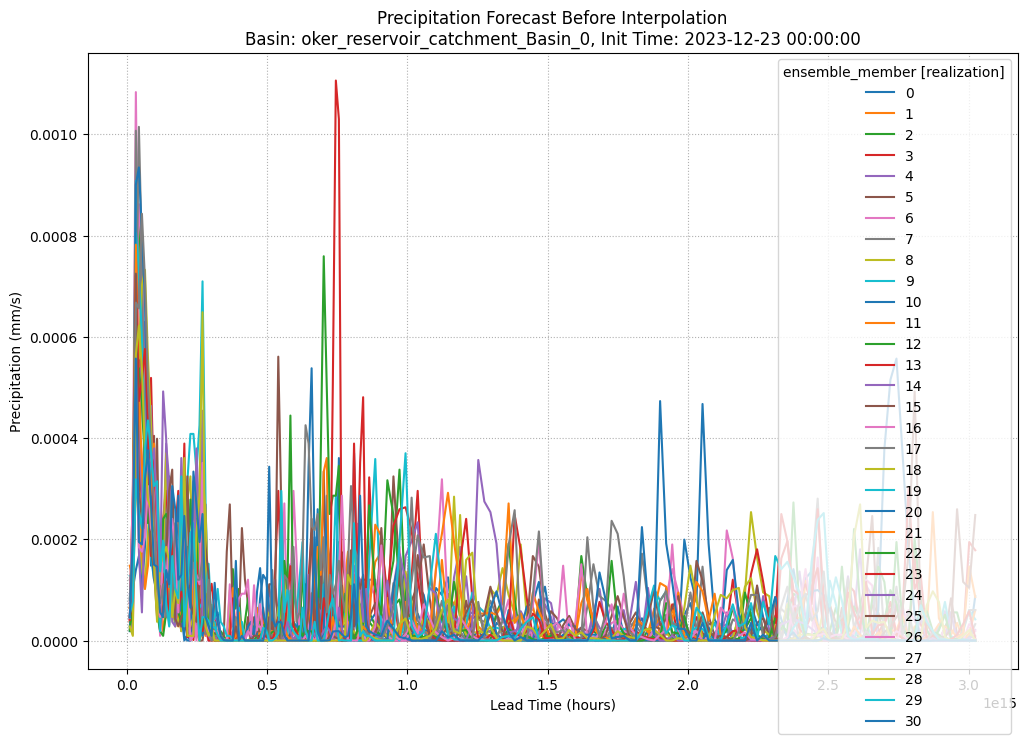

In [10]:
# Select a specific forecast initialization time and basin
forecast_init_time = '2023-12-23 00:00:00'
selected_basin = 'oker_reservoir_catchment_Basin_0'

# Extract the forecast dataset for the selected basin and initialization time
plot_ds = basin_forecasts.sel(init_time=forecast_init_time, basin=selected_basin)

# Plot the ensemble traces for precipitation before interpolation
plt.figure(figsize=(12, 8))
plot_ds['precipitation_surface'].plot(x='lead_time', hue='ensemble_member')
plt.title(f'Precipitation Forecast Before Interpolation\nBasin: {selected_basin}, Init Time: {forecast_init_time}')
plt.xlabel('Lead Time (hours)')
plt.ylabel('Precipitation (mm/s)')
plt.grid(True, linestyle=':')
plt.show()

## Interpolate Forecasts to Hourly Resolution

The NOAA GEFS forecast dataset provides data at varying temporal resolutions:
- For the first 240 hours (10 days): Data is available at 3-hour intervals
- For hours 243-840 (days 11-35): Data is available at 6-hour intervals

This results in 181 lead time steps over the 35-day forecast period.

We interpolate the forecast values to hourly resolution for the first 10 days (240 hours) using linear interpolation. This provides higher temporal granularity for merging with hourly historical data.

In [12]:
# Apply linear interpolation to convert forecast data to hourly resolution for the first 10 days
print("Interpolating forecast data to hourly resolution for the first 10 days...")

# Process the dataset to get hourly resolution
basin_forecasts_hourly = interpolate_to_hourly(basin_forecasts, max_hours=240) # 10 days = 240 hours

# Show the new dataset's time dimension
print(f"\nOriginal forecast lead_times: {len(basin_forecasts.lead_time)} steps")
print(f"Hourly forecast lead_times: {len(basin_forecasts_hourly.lead_time)} steps")

# Compare the resolution before and after
print("\nOriginal forecast lead_time resolution (first 24 hours):")
print(basin_forecasts.lead_time[:9].values)

print("\nNew hourly forecast lead_time resolution (first 24 hours):")
print(basin_forecasts_hourly.lead_time[:25].values)

# Compare dataset dimensions
print(f"\nOriginal forecast dimensions: {dict(basin_forecasts.dims)}")
print(f"Hourly forecast dimensions: {dict(basin_forecasts_hourly.dims)}")

# Preview the hourly forecast dataset
basin_forecasts_hourly

Interpolating forecast data to hourly resolution for the first 10 days...

Original forecast lead_times: 181 steps
Hourly forecast lead_times: 240 steps

Original forecast lead_time resolution (first 24 hours):
[             0 10800000000000 21600000000000 32400000000000
 43200000000000 54000000000000 64800000000000 75600000000000
 86400000000000]

New hourly forecast lead_time resolution (first 24 hours):
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]

Original forecast dimensions: {'basin': 5, 'init_time': 1659, 'ensemble_member': 31, 'lead_time': 181}
Hourly forecast dimensions: {'basin': 5, 'init_time': 1659, 'ensemble_member': 31, 'lead_time': 240}


<xarray.Dataset> Size: 5GB
Dimensions:                                     (basin: 5, init_time: 1659,
                                                 ensemble_member: 31,
                                                 lead_time: 240)
Coordinates:
  * ensemble_member                             (ensemble_member) uint16 62B ...
    expected_forecast_length                    (init_time) timedelta64[ns] 13kB dask.array<chunksize=(1659,), meta=np.ndarray>
    ingested_forecast_length                    (init_time, ensemble_member) timedelta64[ns] 411kB dask.array<chunksize=(1659, 31), meta=np.ndarray>
  * init_time                                   (init_time) datetime64[ns] 13kB ...
    latitude                                    (basin) float64 40B 51.75 ......
    longitude                                   (basin) float64 40B 10.25 ......
    spatial_ref                                 int64 8B ...
  * basin                                       (basin) <U36 720B 'innerste_r...
  * lead_time                                   (lead_time) int64 2kB 1 ... 240
Data variables: (12/21)
    categorical_freezing_rain_surface           (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    categorical_ice_pellets_surface             (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    categorical_rain_surface                    (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    categorical_snow_surface                    (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    downward_long_wave_radiation_flux_surface   (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    downward_short_wave_radiation_flux_surface  (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    ...                                          ...
    temperature_2m                              (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    total_cloud_cover_atmosphere                (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    wind_u_100m                                 (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    wind_u_10m                                  (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    wind_v_100m                                 (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    wind_v_10m                                  (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
Attributes: (12/15)
    dataset_id:           noaa-gefs-forecast-35-day
    dataset_version:      0.2.0
    name:                 NOAA GEFS forecast, 35 day
    description:          Weather forecasts from the Global Ensemble Forecast...
    attribution:          NOAA NWS NCEP GEFS data processed by dynamical.org ...
    spatial_domain:       Global
    ...                   ...
    forecast_domain:      Forecast lead time 0-840 hours (0-35 days) ahead
    forecast_resolution:  Forecast step 0-240 hours: 3 hourly, 243-840 hours:...
    interpolation:        Linear interpolation to hourly resolution
    original_resolution:  3-hourly for first 10 days
    max_forecast_hours:   240
    lead_time_format:     Integer hours from 1 to 240

## Plot Forecast After Interpolation

Visualize the ensemble traces of the forecast for a specific basin after interpolation.

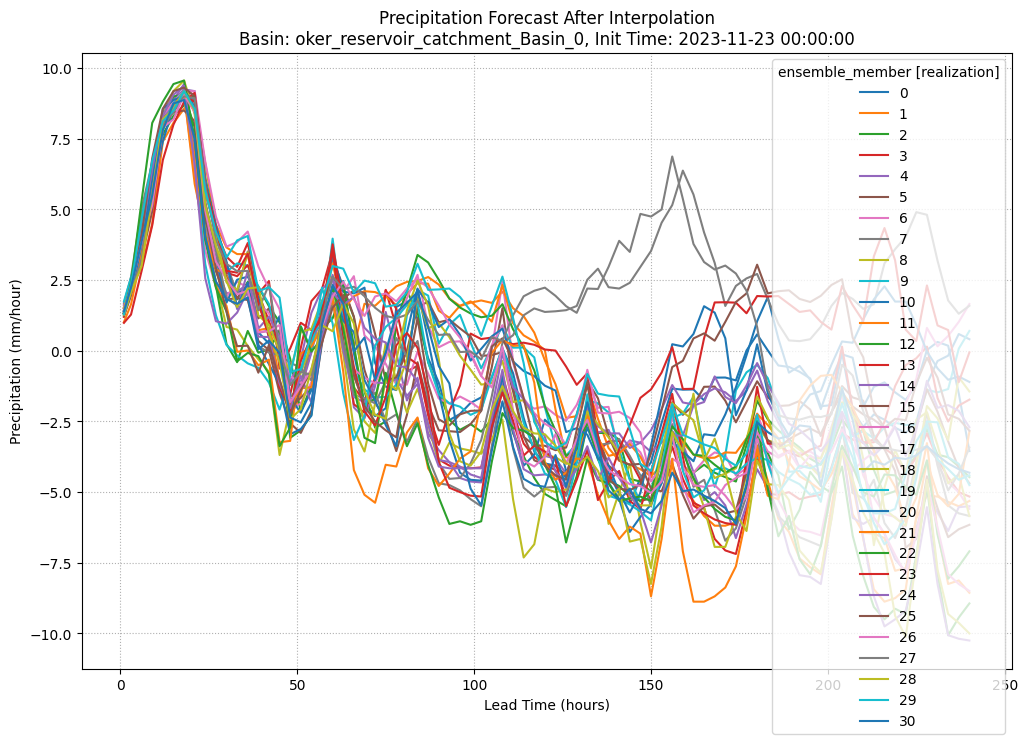

In [13]:
# Select a specific forecast initialization time and basin
forecast_init_time = '2023-11-23 00:00:00'
selected_basin = 'oker_reservoir_catchment_Basin_0'

# Extract the forecast dataset for the selected basin and initialization time
plot_ds = basin_forecasts_hourly.sel(init_time=forecast_init_time, basin=selected_basin)

# Plot the ensemble traces for precipitation after interpolation
plt.figure(figsize=(12, 8))
plot_ds['temperature_2m'].plot(x='lead_time', hue='ensemble_member')
plt.title(f'Precipitation Forecast After Interpolation\nBasin: {selected_basin}, Init Time: {forecast_init_time}')
plt.xlabel('Lead Time (hours)')
plt.ylabel('Precipitation (mm/hour)')
plt.grid(True, linestyle=':')
plt.show()

## Fetch Historical Data

Fetch historical weather data from Open-Meteo for the same basins. The time range will match the forecast initialization times to ensure alignment.

In [14]:
# Determine the date range from the forecast data
start_date_hist = pd.to_datetime(basin_forecasts.init_time.min().values).strftime('%Y-%m-%d')
end_date_hist = pd.to_datetime(basin_forecasts.init_time.max().values).strftime('%Y-%m-%d')
print(f"Historical data range determined by forecast init_times: {start_date_hist} to {end_date_hist}")

# Define historical variables (can customize)
historical_variables = [
    "temperature_2m", "relative_humidity_2m", "precipitation", "rain", "snowfall", 
    "soil_moisture_0_to_7cm", "soil_moisture_7_to_28cm", "soil_moisture_28_to_100cm", 
    "soil_moisture_100_to_255cm", "et0_fao_evapotranspiration", "surface_pressure", 
    "snow_depth_water_equivalent"
]

# Fetch historical data
basin_historical_data = fetch_historical_for_basins(centroids, start_date_hist, end_date_hist, historical_variables)

# Display historical data summary
if basin_historical_data:
    display(basin_historical_data)
else:
    print("Failed to fetch historical data.")

Historical data range determined by forecast init_times: 2020-10-01 to 2025-04-16
Fetching historical data from 2020-10-01 to 2025-04-16 for 5 basins...
  Fetching data for: innerste_reservoir_catchment_Basin_0 (Lat: 51.8345, Lon: 10.3078)
  Fetching data for: oker_reservoir_catchment_Basin_0 (Lat: 51.8165, Lon: 10.4473)
  Fetching data for: ecker_reservoir_catchment_Basin_0 (Lat: 51.8101, Lon: 10.5841)
  Fetching data for: soese_reservoir_catchment_Basin_0 (Lat: 51.7523, Lon: 10.3832)
  Fetching data for: grane_reservoir_catchment_Basin_0 (Lat: 51.8844, Lon: 10.3572)
Successfully fetched and combined historical data for 5 basins.
Historical Dataset dimensions: {'basin': 5, 'time': 39816}


<xarray.Dataset> Size: 10MB
Dimensions:                      (basin: 5, time: 39816)
Coordinates:
  * time                         (time) datetime64[ns] 319kB 2020-10-01 ... 2...
  * basin                        (basin) <U36 720B 'innerste_reservoir_catchm...
Data variables:
    temperature_2m               (basin, time) float32 796kB 10.82 10.27 ... nan
    relative_humidity_2m         (basin, time) float32 796kB 92.3 91.96 ... nan
    precipitation                (basin, time) float32 796kB 0.0 0.0 ... nan nan
    rain                         (basin, time) float32 796kB 0.0 0.0 ... nan nan
    snowfall                     (basin, time) float32 796kB 0.0 0.0 ... nan nan
    soil_moisture_0_to_7cm       (basin, time) float32 796kB 0.356 0.356 ... nan
    soil_moisture_7_to_28cm      (basin, time) float32 796kB 0.349 0.349 ... nan
    soil_moisture_28_to_100cm    (basin, time) float32 796kB 0.307 0.307 ... nan
    soil_moisture_100_to_255cm   (basin, time) float32 796kB 0.352 0.352 ... nan
    et0_fao_evapotranspiration   (basin, time) float32 796kB 0.0 0.0 ... nan nan
    surface_pressure             (basin, time) float32 796kB 953.2 952.8 ... nan
    snow_depth_water_equivalent  (basin, time) float32 796kB nan nan ... nan nan
Attributes:
    latitude:               51.845340728759766
    longitude:              10.365631103515625
    elevation:              495.0
    timezone:               None
    timezone_abbreviation:  None
    utc_offset_seconds:     0
    api_source:             https://archive-api.open-meteo.com/v1/archive
    api_model:              best_match

## Merge Historical and Forecast Data

Combine the fetched historical data and the interpolated hourly forecast data into a single xarray Dataset. The forecast `init_time` coordinate is renamed to `time` to align with the historical data.

In [17]:
# Rename 'init_time' in forecast data to 'time' for merging
basin_forecasts_hourly_renamed = basin_forecasts_hourly.rename({'init_time': 'time'})

# --- Add chunking for historical data ---
if basin_historical_data is not None:
    print("Chunking historical data...")
    basin_historical_data = basin_historical_data.chunk({'time': 'auto', 'basin': 'auto'})
    print("Historical data chunked.")
    # Display chunking info for a sample variable
    if 'temperature_2m' in basin_historical_data:
        print(f"Sample historical variable chunks ('temperature_2m'): {basin_historical_data['temperature_2m'].chunksizes}")
    elif basin_historical_data.data_vars:
        first_var = list(basin_historical_data.data_vars)[0]
        print(f"Sample historical variable chunks ('{first_var}'): {basin_historical_data[first_var].chunksizes}")
# --- End of added chunking ---

# Identify conflicting variable names (present in both historical and forecast)
# Ensure basin_historical_data is not None before accessing data_vars
conflicting_vars = []
if basin_historical_data is not None:
    conflicting_vars = [var for var in basin_historical_data.data_vars if var in basin_forecasts_hourly_renamed.data_vars]

# Rename conflicting variables in the historical dataset
rename_dict = {var: f"{var}_hist" for var in conflicting_vars}
basin_historical_data_renamed = basin_historical_data.rename(rename_dict) if basin_historical_data is not None else None
if rename_dict:
    print(f"Renamed conflicting historical variables: {list(rename_dict.values())}")

# Merge the full historical and forecast datasets using 'no_conflicts'
print("Merging full historical and forecast datasets...")
if basin_historical_data_renamed is not None:
    try:
        basin_forecast_historical_hourly = xr.merge([basin_historical_data_renamed, basin_forecasts_hourly_renamed], compat='no_conflicts')
        print("\nMerge successful.")
        print(f"Combined Dataset dimensions: {dict(basin_forecast_historical_hourly.dims)}")
        # Display variable names to confirm merge
        print("\nVariables in combined dataset:")
        for var_name in basin_forecast_historical_hourly.data_vars:
             print(f"  - {var_name}: {basin_forecast_historical_hourly[var_name].dims}")
        display(basin_forecast_historical_hourly)
    except Exception as e:
        print(f"\nMerge failed: {e}")
        # Fallback or further error handling
        basin_forecast_historical_hourly = None
else:
    print("Skipping merge as historical data failed to load or was not renamed.")
    basin_forecast_historical_hourly = basin_forecasts_hourly_renamed 
    print("Proceeding with only forecast data.")

Chunking historical data...
Historical data chunked.
Sample historical variable chunks ('temperature_2m'): Frozen({'basin': (5,), 'time': (39816,)})
Renamed conflicting historical variables: ['temperature_2m_hist', 'relative_humidity_2m_hist']
Merging full historical and forecast datasets...

Merge successful.
Combined Dataset dimensions: {'time': 39816, 'basin': 5, 'ensemble_member': 31, 'lead_time': 240}

Variables in combined dataset:
  - temperature_2m_hist: ('basin', 'time')
  - relative_humidity_2m_hist: ('basin', 'time')
  - precipitation: ('basin', 'time')
  - rain: ('basin', 'time')
  - snowfall: ('basin', 'time')
  - soil_moisture_0_to_7cm: ('basin', 'time')
  - soil_moisture_7_to_28cm: ('basin', 'time')
  - soil_moisture_28_to_100cm: ('basin', 'time')
  - soil_moisture_100_to_255cm: ('basin', 'time')
  - et0_fao_evapotranspiration: ('basin', 'time')
  - surface_pressure: ('basin', 'time')
  - snow_depth_water_equivalent: ('basin', 'time')
  - categorical_freezing_rain_surfac

<xarray.Dataset> Size: 124GB
Dimensions:                                     (time: 39816, basin: 5,
                                                 ensemble_member: 31,
                                                 lead_time: 240)
Coordinates:
  * time                                        (time) datetime64[ns] 319kB 2...
  * basin                                       (basin) <U36 720B 'innerste_r...
  * ensemble_member                             (ensemble_member) uint16 62B ...
  * lead_time                                   (lead_time) int64 2kB 1 ... 240
    expected_forecast_length                    (time) timedelta64[ns] 319kB dask.array<chunksize=(1659,), meta=np.ndarray>
    ingested_forecast_length                    (time, ensemble_member) timedelta64[ns] 10MB dask.array<chunksize=(1659, 31), meta=np.ndarray>
    latitude                                    (basin) float64 40B 51.75 ......
    longitude                                   (basin) float64 40B 10.25 ......
    spatial_ref                                 int64 8B ...
Data variables: (12/33)
    temperature_2m_hist                         (basin, time) float32 796kB dask.array<chunksize=(5, 39816), meta=np.ndarray>
    relative_humidity_2m_hist                   (basin, time) float32 796kB dask.array<chunksize=(5, 39816), meta=np.ndarray>
    precipitation                               (basin, time) float32 796kB dask.array<chunksize=(5, 39816), meta=np.ndarray>
    rain                                        (basin, time) float32 796kB dask.array<chunksize=(5, 39816), meta=np.ndarray>
    snowfall                                    (basin, time) float32 796kB dask.array<chunksize=(5, 39816), meta=np.ndarray>
    soil_moisture_0_to_7cm                      (basin, time) float32 796kB dask.array<chunksize=(5, 39816), meta=np.ndarray>
    ...                                          ...
    temperature_2m                              (basin, time, ensemble_member, lead_time) float32 6GB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    total_cloud_cover_atmosphere                (basin, time, ensemble_member, lead_time) float32 6GB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    wind_u_100m                                 (basin, time, ensemble_member, lead_time) float32 6GB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    wind_u_10m                                  (basin, time, ensemble_member, lead_time) float32 6GB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    wind_v_100m                                 (basin, time, ensemble_member, lead_time) float32 6GB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    wind_v_10m                                  (basin, time, ensemble_member, lead_time) float32 6GB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
Attributes:
    latitude:               51.845340728759766
    longitude:              10.365631103515625
    elevation:              495.0
    timezone:               None
    timezone_abbreviation:  None
    utc_offset_seconds:     0
    api_source:             https://archive-api.open-meteo.com/v1/archive
    api_model:              best_match

## Visualize Combined Historical and Forecast Data

Plot the historical data for the two weeks leading up to the latest forecast initialization time, followed by the ensemble forecast (median, uncertainty band, and individual members) for temperature and precipitation.

Targeting plot around Christmas 2023 Forecast Initialization Time (UTC): 2023-12-23 00:00:00
Using Initialization Time for Plotting (UTC): 2023-12-23 00:00:00
Preparing plot for basin: oker_reservoir_catchment_Basin_0
Historical data window for plot (UTC): 2023-12-16 00:00 to 2023-12-23 00:00:00
Historical data window for plot (UTC): 2023-12-16 00:00 to 2023-12-23 00:00:00
Successfully selected historical slice for plot (Range: 2023-12-16T00:00:00.000000000 to 2023-12-23T00:00:00.000000000)
Successfully selected forecast data for plot (Init time: 2023-12-23T00:00:00.000000000)
Loading data slices into memory for plotting...
Successfully selected historical slice for plot (Range: 2023-12-16T00:00:00.000000000 to 2023-12-23T00:00:00.000000000)
Successfully selected forecast data for plot (Init time: 2023-12-23T00:00:00.000000000)
Loading data slices into memory for plotting...
Finished loading data slices.
Plotting 169 valid historical temperature points.
Plotting temperature ensemble me

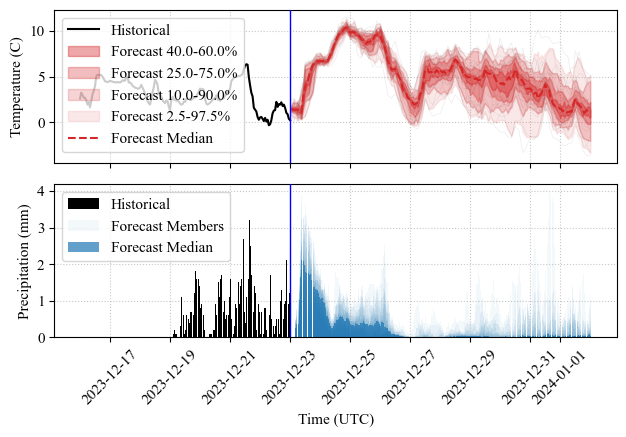

In [20]:
# --- Visualization Configuration ---

# --- Figure and Font Size ---
FIG_WIDTH = 6.4
FIG_HEIGHT = 5
FONT_SIZE = 11

selected_basin = basin_forecast_historical_hourly['basin'].values[1] # Select Oker reservoir catchment for plotting
historical_days = 7 # Days of historical data before the forecast start
# Define four quantile pairs for temperature uncertainty
temp_uncertainty_quantiles = [
    [0.025, 0.975], # Outer band (95% interval)
    [0.1,   0.9],   # Next band (80% interval)
    [0.25,  0.75],  # Inner band (50% interval)
    [0.4,   0.6]    # Innermost band (20% interval)
]
# Define corresponding colors/alphas for temperature bands (lighter for wider bands)
temp_band_colors = ['#d62728'] * 4 # Base red color for all bands
temp_band_alphas = [0.1, 0.2, 0.3, 0.4] # Lighter alpha for outer, progressively darker

# PERFORMANCE NOTE: Setting show_members to False significantly speeds up plotting.
show_members = True # Whether to plot individual ensemble members

# Variable names (adjust if changed during merge)
historical_temp_var = 'temperature_2m_hist'
historical_precip_var = 'precipitation' # Assuming Open-Meteo provides hourly precipitation (mm)
forecast_temp_var = 'temperature_2m'
forecast_precip_var = 'precipitation_surface' # Forecast precipitation (mm/s)

# Conversion factor for precipitation: mm/s to mm/hr
MM_PER_S_TO_MM_PER_HR = 3600

# --- Define Specific Time for Plotting (e.g., Christmas 2023) ---
plot_forecast_init_time = None
if 'basin_forecast_historical_hourly' in locals() and basin_forecast_historical_hourly is not None:
    christmas_2023_target_time = pd.Timestamp('2023-12-23 00:00:00')
    print(f"Targeting plot around Christmas 2023 Forecast Initialization Time (UTC): {christmas_2023_target_time.strftime('%Y-%m-%d %H:%M:%S')}")
    
    # Find the closest available initialization time in the *merged* dataset
    available_times = pd.to_datetime(basin_forecast_historical_hourly.time.values)
    if christmas_2023_target_time in available_times:
        plot_forecast_init_time = christmas_2023_target_time
    else:
        time_diffs = np.abs(available_times - christmas_2023_target_time)
        closest_idx = time_diffs.argmin()
        plot_forecast_init_time = available_times[closest_idx]
        print(f"Exact Christmas date not found in data, using closest available init time for plotting: {plot_forecast_init_time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Using Initialization Time for Plotting (UTC): {plot_forecast_init_time.strftime('%Y-%m-%d %H:%M:%S')}")
else:
     print("Merged dataset not available to determine plot initialization time.")

# --- Data Preparation for Plotting ---
plot_data_available = False
historical_temp_data = None
historical_precip_data = None
latest_forecast_temp_members = None
forecast_median_temp = None
forecast_quantile_temp_all = None
latest_forecast_precip_members = None
forecast_median_precip = None
forecast_quantile_precip = None
forecast_time_axis = None

# Proceed only if merged data and a plot time are available
if 'basin_forecast_historical_hourly' in locals() and basin_forecast_historical_hourly is not None and plot_forecast_init_time is not None:
    print(f"Preparing plot for basin: {selected_basin}")

    # Select data for the chosen basin
    basin_data = basin_forecast_historical_hourly.sel(basin=selected_basin)

    # Define time windows relative to the *plot* initialization time
    hist_end_time = plot_forecast_init_time
    hist_start_time = hist_end_time - timedelta(days=historical_days)
    print(f"Historical data window for plot (UTC): {hist_start_time.strftime('%Y-%m-%d %H:%M')} to {hist_end_time.strftime('%Y-%m-%d %H:%M:%S')}")

    # Extract historical and forecast slices based on plot_forecast_init_time
    try:
        # Slice historical data up to the plot init time
        historical_slice = basin_data.sel(time=slice(hist_start_time, hist_end_time))
        # Select the specific forecast initialized at plot_forecast_init_time
        latest_forecast = basin_data.sel(time=plot_forecast_init_time)
        print(f"Successfully selected historical slice for plot (Range: {historical_slice.time.min().values} to {historical_slice.time.max().values})")
        print(f"Successfully selected forecast data for plot (Init time: {latest_forecast.time.values})")
        plot_data_available = True
    except KeyError as e:
        print(f"Error selecting data slices for plot: {e}. Check time coordinates ({plot_forecast_init_time}) and availability.")
    except Exception as e:
        print(f"An unexpected error occurred during data selection for plot: {e}")

    if plot_data_available:
        # Extract specific variables if slices are valid
        # --- Load data into memory before plotting ---
        print("Loading data slices into memory for plotting...")
        try:
            # Historical Data
            if historical_temp_var in historical_slice:
                historical_temp_data = historical_slice[historical_temp_var].compute() # Load historical temp
                if historical_temp_data.isnull().all():
                    print(f"Warning: Historical temperature ('{historical_temp_var}') for plot is all NaN.")
            else:
                print(f"Warning: Historical temperature variable '{historical_temp_var}' not found for plot.")

            if historical_precip_var in historical_slice:
                historical_precip_data = historical_slice[historical_precip_var].compute() # Load historical precip
                if historical_precip_data.isnull().all():
                    print(f"Warning: Historical precipitation ('{historical_precip_var}') for plot is all NaN.")
            else:
                print(f"Warning: Historical precipitation variable '{historical_precip_var}' not found for plot.")

            # Forecast Data
            if forecast_temp_var in latest_forecast:
                latest_forecast_temp_members = latest_forecast[forecast_temp_var].compute() # Load forecast temp members
                forecast_median_temp = latest_forecast_temp_members.median(dim='ensemble_member')
                # Calculate all required quantiles at once for efficiency
                all_temp_quantiles_needed = sorted(list(set(q for pair in temp_uncertainty_quantiles for q in pair)))
                forecast_quantile_temp_all = latest_forecast_temp_members.quantile(all_temp_quantiles_needed, dim='ensemble_member')
            else:
                print(f"Warning: Forecast temperature variable '{forecast_temp_var}' not found for plot.")
                forecast_quantile_temp_all = None

            if forecast_precip_var in latest_forecast:
                latest_forecast_precip_members = latest_forecast[forecast_precip_var].compute() # Load forecast precip members
                forecast_median_precip = latest_forecast_precip_members.median(dim='ensemble_member')
                # Keep precipitation quantile calculation as is, or adjust if needed
                precip_uncertainty_quantiles = [0.05, 0.95] # Example: Keep 90% for precip
                forecast_quantile_precip = latest_forecast_precip_members.quantile(precip_uncertainty_quantiles, dim='ensemble_member')
            else:
                print(f"Warning: Forecast precipitation variable '{forecast_precip_var}' not found for plot.")
                forecast_quantile_precip = None

            # Calculate forecast time axis relative to plot_forecast_init_time
            forecast_lead_hours = latest_forecast['lead_time'].values
            forecast_time_axis = plot_forecast_init_time + pd.to_timedelta(forecast_lead_hours, unit='h')
            print("Finished loading data slices.")
            # --- End loading data ---

        except Exception as e:
            print(f"Error extracting or loading variables for plotting: {e}")
            import traceback
            traceback.print_exc()
            plot_data_available = False # Prevent plotting if extraction fails
else:
    print("Combined dataset 'basin_forecast_historical_hourly' or 'plot_forecast_init_time' not found/determined. Cannot prepare plot data.")

# --- Create Plot ---
if plot_data_available:
    # Set the default font and size
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': FONT_SIZE
    })
    
    fig, axes = plt.subplots(2, 1, figsize=(FIG_WIDTH, FIG_HEIGHT), sharex=True)

    # --- Temperature Plot (ax1) ---
    ax1 = axes[0]
    temp_units = '°C'
    temp_forecast_color = '#d62728' # Base Red for temperature forecast median
    if forecast_temp_var in latest_forecast:
        # Use .attrs which should exist even after compute()
        temp_units = latest_forecast_temp_members.attrs.get('units', '°C')

    # Plot Historical Temperature (Keep black for distinction)
    if historical_temp_data is not None and not historical_temp_data.isnull().all():
        valid_historical_temp = historical_temp_data.dropna(dim='time')
        if valid_historical_temp.size > 0:
            ax1.plot(valid_historical_temp['time'].values, valid_historical_temp.values,
                     label=f'Historical', color='black', linewidth=1.5, zorder=5)
            print(f"Plotting {valid_historical_temp.size} valid historical temperature points.")
        else:
            print("No valid historical temperature points to plot after dropping NaNs.")

    # Plot Forecast Temperature (Multiple quantile bands in red shades)
    if forecast_median_temp is not None and forecast_quantile_temp_all is not None and forecast_time_axis is not None:
        # Plot quantile bands (plot wider bands first - reverse iteration)
        # Ensure colors/alphas lists match the quantiles list length
        num_bands = len(temp_uncertainty_quantiles)
        plot_colors = temp_band_colors if len(temp_band_colors) == num_bands else [temp_band_colors[0]] * num_bands
        plot_alphas = temp_band_alphas if len(temp_band_alphas) == num_bands else [0.2] * num_bands # Fallback alpha
        
        for i, (q_pair, color, alpha) in enumerate(zip(reversed(temp_uncertainty_quantiles), reversed(plot_colors), reversed(plot_alphas))):
            q_low, q_high = q_pair
            ax1.fill_between(forecast_time_axis,
                             forecast_quantile_temp_all.sel(quantile=q_low).values,
                             forecast_quantile_temp_all.sel(quantile=q_high).values,
                             color=color, alpha=alpha,
                             label=f'Forecast {q_low*100:.1f}-{q_high*100:.1f}%', # Use .1f for 97.5 etc.
                             zorder=3.0 - i*0.1) # Ensure bands stack correctly

        # Median - Use specified base red color
        median_line, = ax1.plot(forecast_time_axis, forecast_median_temp.values,
                 label=f'Forecast Median', linestyle='--', color=temp_forecast_color, zorder=4)

        # Ensemble Members - Use a neutral color like grey (keep color='grey')
        if show_members and latest_forecast_temp_members is not None:
            print("Plotting temperature ensemble members...")
            ax1.plot(forecast_time_axis, latest_forecast_temp_members.values.T,
                     color='grey', alpha=0.15, linewidth=0.5, zorder=2)
            print("Finished plotting temperature members.")

    ax1.set_ylabel(f"Temperature ({temp_units})") # Updated unit format
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle=':', alpha=0.7)
    # Use plot_forecast_init_time for the vertical line (Keep blue for distinction)
    ax1.axvline(plot_forecast_init_time, color='blue', linestyle='-', linewidth=1, label='Forecast Start', zorder=6)

    # --- Precipitation Plot (ax2) ---
    ax2 = axes[1]
    precip_units_hist = 'mm' # Assuming historical is hourly accumulation
    precip_units_fcst = 'mm' # After conversion
    precip_forecast_color = '#1f77b4' # Blue for precipitation forecast
    forecast_bar_width_days = (forecast_time_axis[1] - forecast_time_axis[0]) / np.timedelta64(1, 'D') if len(forecast_time_axis) > 1 else 1/24

    # Plot Historical Precipitation (Bars - Keep black for distinction)
    if historical_precip_data is not None and not historical_precip_data.isnull().all():
        valid_historical_precip = historical_precip_data.dropna(dim='time')
        if valid_historical_precip.size > 0:
            hist_time_diff = np.diff(valid_historical_precip['time'].values)
            hist_bar_width_days = (hist_time_diff[0] / np.timedelta64(1, 'D')) if len(hist_time_diff) > 0 else (1/24)
            ax2.bar(valid_historical_precip['time'].values, valid_historical_precip.values,
                    width=hist_bar_width_days * 0.9, label=f'Historical', color='black', align='edge', zorder=3)
            print(f"Plotting {valid_historical_precip.size} valid historical precipitation points.")
        else:
            print("No valid historical precipitation points to plot after dropping NaNs.")

    # Plot Forecast Precipitation (Use specified blue color)
    if forecast_median_precip is not None and forecast_time_axis is not None:
        # Ensemble Members (Bars) - Use the specified blue color with low alpha
        if show_members and latest_forecast_precip_members is not None:
            print("Plotting precipitation ensemble members...")
            members_precip_mmhr = latest_forecast_precip_members.values * MM_PER_S_TO_MM_PER_HR
            for i in range(members_precip_mmhr.shape[0]):
                label = f'Forecast Members' if i == 0 else None
                # Use the specified blue color with alpha
                ax2.bar(forecast_time_axis, members_precip_mmhr[i, :],
                        width=forecast_bar_width_days * 0.9, color=precip_forecast_color, alpha=0.05, align='edge', label=label, zorder=1)
            print("Finished plotting precipitation members.")

        # Median (Bars) - Use the specified blue color
        forecast_precip_mmhr_median = forecast_median_precip.values * MM_PER_S_TO_MM_PER_HR
        ax2.bar(forecast_time_axis, forecast_precip_mmhr_median,
                width=forecast_bar_width_days * 0.9, label=f'Forecast Median', color=precip_forecast_color, alpha=0.7, align='edge', zorder=2)

    ax2.set_ylabel(f"Precipitation ({precip_units_fcst})") # Updated unit format
    ax2.legend(loc='upper left')
    ax2.grid(True, linestyle=':', alpha=0.7)
    # Use plot_forecast_init_time for the vertical line (Keep blue for distinction)
    ax2.axvline(plot_forecast_init_time, color='blue', linestyle='-', linewidth=1, zorder=4)

    # --- Final Formatting ---
    plt.xlabel("Time (UTC)")
    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0.03, 1, 0.93]) # Adjust layout to prevent title/label overlap with new size
    
    # --- Save Plot (BEFORE plt.show()) ---
    plot_filename = os.path.join(output_dir, f"forecast_plot_{selected_basin}_{plot_forecast_init_time.strftime('%Y%m%d_%H%M')}.pdf")
    try:
        fig.savefig(plot_filename, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Plot saved to {plot_filename}")
    except Exception as e:
        print(f"Error saving plot: {e}")
        
    # --- Show Plot ---
    plt.show()
else:
    print("Skipping plot generation because necessary data could not be prepared.")